In [2]:
%run packages.py

2025-01-09 16:10:13.037613: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
from data_import_enginnering import DataImportEnginnering
from metric_selection import Pair_Selection
from data_visualization import Data_Visualization
import importlib

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

# 1. DATA

## 1.1. Importation of data into a dictionary

In [4]:
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
tables = pd.read_html(url)
Stock_list = pd.DataFrame(tables[0])
Stock_list.drop(['Security','GICS Sub-Industry','Headquarters Location','CIK','Founded'],axis = 1, inplace=True)
Stock_list['Date added'] = pd.to_datetime(Stock_list['Date added'])
Stock_list = Stock_list[( Stock_list['Date added'] < '2019-12-31') & (Stock_list['Date added']>'2015-01-01')][['Symbol','GICS Sector']]

In [5]:
stock_list = list(Stock_list['Symbol'].unique())
Stock_list_sector = Stock_list.groupby('GICS Sector')['Symbol'].unique().to_dict()
sector_list = list(Stock_list_sector.keys())
pairs = {k:[tuple(sorted((i,j))) for i in Stock_list_sector[k] for j in Stock_list_sector[k] if j!=i] for k in sector_list}
pairs = {k :sorted(list(set(pairs[k]))) for k in sector_list}

In [6]:
start_date = '2018-01-01'
end_date = '2019-12-31'
period = '1d'
colone = ['Close']


In [7]:
Enginner = DataImportEnginnering(stock_list,start_date=start_date,end_date=end_date,period=period,colone=colone)

In [8]:
raw_data = Enginner.RawData()
raw_data

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

{'AOS': Price           Close
 Ticker            AOS
 Date                 
 2018-01-02  54.426800
 2018-01-03  54.754089
 2018-01-04  55.010605
 2018-01-05  55.718254
 2018-01-08  55.983624
 ...               ...
 2019-12-23  43.067318
 2019-12-24  43.396221
 2019-12-26  43.615482
 2019-12-27  43.679440
 2019-12-30  43.460167
 
 [502 rows x 1 columns],
 'AMD': Price           Close
 Ticker            AMD
 Date                 
 2018-01-02  10.980000
 2018-01-03  11.550000
 2018-01-04  12.120000
 2018-01-05  11.880000
 2018-01-08  12.280000
 ...               ...
 2019-12-23  45.459999
 2019-12-24  46.540001
 2019-12-26  46.630001
 2019-12-27  46.180000
 2019-12-30  45.520000
 
 [502 rows x 1 columns],
 'ALB': Price            Close
 Ticker             ALB
 Date                  
 2018-01-02  120.240570
 2018-01-03  120.478264
 2018-01-04  119.042999
 2018-01-05  120.414230
 2018-01-08  125.652458
 ...                ...
 2019-12-23   68.524300
 2019-12-24   68.420219
 2019-12-26   68.

## 1.2. Normalisation of data

In [9]:
raw_data_normalized = {}
for key, value in raw_data.items():
    raw_data_normalized[key] = Enginner.normalize(value)

raw_data_normalized

{'AOS': Price          Close
 Ticker           AOS
 Date                
 2018-01-02  0.761192
 2018-01-03  0.775195
 2018-01-04  0.786170
 2018-01-05  0.816447
 2018-01-08  0.827801
 ...              ...
 2019-12-23  0.275175
 2019-12-24  0.289248
 2019-12-26  0.298629
 2019-12-27  0.301365
 2019-12-30  0.291984
 
 [502 rows x 1 columns],
 'AMD': Price          Close
 Ticker           AMD
 Date                
 2018-01-02  0.039084
 2018-01-03  0.054447
 2018-01-04  0.069811
 2018-01-05  0.063342
 2018-01-08  0.074124
 ...              ...
 2019-12-23  0.968464
 2019-12-24  0.997574
 2019-12-26  1.000000
 2019-12-27  0.987871
 2019-12-30  0.970081
 
 [502 rows x 1 columns],
 'ALB': Price          Close
 Ticker           ALB
 Date                
 2018-01-02  0.922865
 2018-01-03  0.926253
 2018-01-04  0.905796
 2018-01-05  0.925340
 2018-01-08  1.000000
 ...              ...
 2019-12-23  0.185756
 2019-12-24  0.184273
 2019-12-26  0.186565
 2019-12-27  0.180093
 2019-12-30  0.179014
 

In [10]:
dataframe_normalized = Enginner.Dictionnary_to_Dataframe(raw_data_normalized)
raw_dataframe = Enginner.Dictionnary_to_Dataframe(raw_data)

In [11]:
dataframe_normalized= dataframe_normalized.stack(future_stack=True).stack(future_stack=True).droplevel(level =2).unstack()
raw_dataframe= raw_dataframe.stack(future_stack=True).stack(future_stack=True).droplevel(level =2).unstack()

In [12]:
#raw_data = first dictionnary with non normalised data for each ticker
#raw_data_normalized = dictionnary with normalised data
#raw_dataframe = raw_data into dataframe
#dataframe_normalized = raw_data_normalized into dataframe

# 2. Pair selection

In [13]:
Metric = Pair_Selection(dataframe_normalized,number_of_pair=2,stock_list_sector=Stock_list_sector,sector_list=sector_list,sector_neutral = True)

In [14]:
distance = Metric.compute_euclidian_distance()

In [15]:
selected_pairs = Metric.paire_selection(distance,number_of_pair=2,stock_list_sector=Stock_list_sector,sector_list=sector_list,pairs=pairs)

In [16]:
selected_pairs['Energy'] = [selected_pairs['Energy'][0]]
selected_pairs

{'Communication Services': [('FOX', 'FOXA'), ('TMUS', 'LYV')],
 'Consumer Discretionary': [('MGM', 'LKQ'), ('NVR', 'HLT')],
 'Consumer Staples': [('LW', 'CHD'), ('LW', 'KHC')],
 'Energy': [('FANG', 'BKR')],
 'Financials': [('MSCI', 'GPN'), ('GPN', 'CPAY')],
 'Health Care': [('IQV', 'COO'), ('STE', 'IQV')],
 'Industrials': [('TDG', 'CPRT'), ('LDOS', 'CPRT')],
 'Information Technology': [('CDW', 'ANSS'), ('SNPS', 'CDNS')],
 'Materials': [('PKG', 'DOW'), ('DD', 'ALB')],
 'Real Estate': [('UDR', 'O'), ('REG', 'FRT')],
 'Utilities': [('AWK', 'LNT'), ('SRE', 'AWK')]}

In [30]:
data1 = dataframe_normalized.copy()
data2 = raw_dataframe.copy()
# The goal would be to stock every small data frame in a dictionnay to help doing the steps for the reste 
dataframes_dictionnary_norm = {}
dataframes_dictionnary_raw ={}
for sector in sector_list: 
    for value in selected_pairs[sector]:
        
        dataframes_dictionnary_norm[value] = data1[list(value)].copy()
        dataframes_dictionnary_raw[value] = data2[list(value)].copy()

In [18]:
#dataframes_dictionnary_norm = dictionnary containing normalized data for each of the selected pairs
#dataframes_dictionnary_raw = dictionnary containing raw data for each of the selected pairs

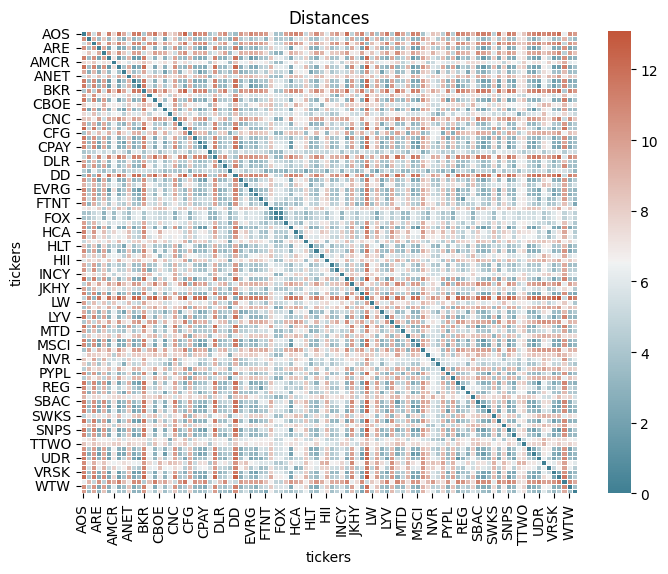

In [31]:
plots = Data_Visualization()
plots.metric(distance, "Distances","tickers","tickers")

<Figure size 1500x2000 with 0 Axes>

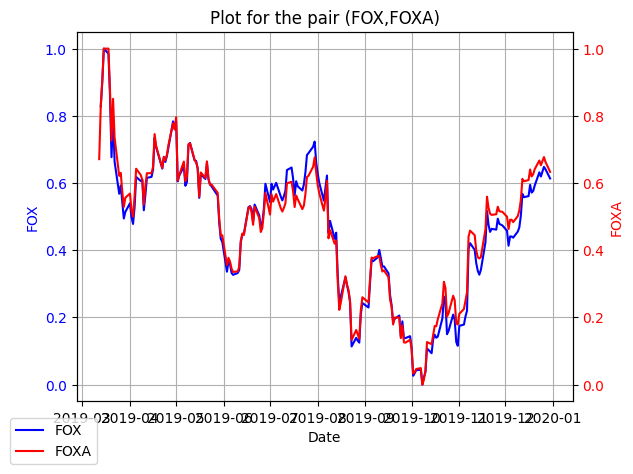

In [32]:
plots.pair_historic(dataframes_dictionnary_norm,('FOX', 'FOXA'))

# 3. Computation of spreads

In [33]:
from Spread import Spread


{('FOX',
  'FOXA'): Ticker           FOX      FOXA  Delta_norm
 Date                                      
 2018-01-02       NaN       NaN         NaN
 2018-01-03       NaN       NaN         NaN
 2018-01-04       NaN       NaN         NaN
 2018-01-05       NaN       NaN         NaN
 2018-01-08       NaN       NaN         NaN
 ...              ...       ...         ...
 2019-12-23  0.631741  0.666870   -0.879843
 2019-12-24  0.619287  0.652902   -0.828322
 2019-12-26  0.648024  0.677233   -0.678444
 2019-12-27  0.640840  0.662815   -0.432351
 2019-12-30  0.613539  0.633076   -0.349416
 
 [502 rows x 3 columns],
 ('TMUS',
  'LYV'): Ticker          TMUS       LYV  Delta_norm
 Date                                      
 2018-01-02  0.295082  0.163553    1.706945
 2018-01-03  0.280084  0.159762    1.602152
 2018-01-04  0.258807  0.153263    1.463974
 2018-01-05  0.314615  0.181695    1.719945
 2018-01-08  0.332054  0.174384    1.951374
 ...              ...       ...         ...
 2019-12-23

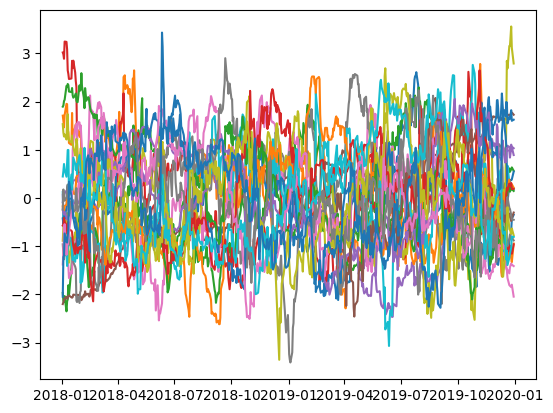

In [34]:
for key,values in dataframes_dictionnary_norm.items():

    values.loc[:,'Delta'] = values.loc[:,key[0]] - values.loc[:,key[1]]
    values.loc[:,'Delta_norm'] = (values.loc[:,'Delta'] - values.loc[:,'Delta'].mean()) / values.loc[:,'Delta'].std()
    values.drop(['Delta'], axis = 1, inplace=True )
    plt.plot(dataframes_dictionnary_norm[key].loc[:,'Delta_norm'])

dataframes_dictionnary_norm



# 4. Signal creation

In [36]:
from portfolio import Signaux

In [37]:
"""data = np.array(dataframes_dictionnary_norm[('FOX','FOXA')]['Delta_norm'])
signaux = Signaux(data, 2)
signaux.entry_points_up()"""
for key,value in dataframes_dictionnary_norm.items():
    signaux = Signaux(value,2)
    value['trading_signals_buy'] = signaux.trading_signals_buy('Delta_norm')

In [38]:
for key,value in dataframes_dictionnary_norm.items():
    print(key)
    print(value)

('FOX', 'FOXA')
Ticker           FOX      FOXA  Delta_norm  Trading_points  \
Date                                                         
2018-01-02       NaN       NaN         NaN               0   
2018-01-03       NaN       NaN         NaN               0   
2018-01-04       NaN       NaN         NaN               0   
2018-01-05       NaN       NaN         NaN               0   
2018-01-08       NaN       NaN         NaN               0   
...              ...       ...         ...             ...   
2019-12-23  0.631741  0.666870   -0.879843               0   
2019-12-24  0.619287  0.652902   -0.828322               0   
2019-12-26  0.648024  0.677233   -0.678444               0   
2019-12-27  0.640840  0.662815   -0.432351               0   
2019-12-30  0.613539  0.633076   -0.349416               0   

Ticker      trading_signals_buy  
Date                             
2018-01-02                    0  
2018-01-03                    0  
2018-01-04                    0  
2018-01

In [39]:
data_viz = Data_Visualization()

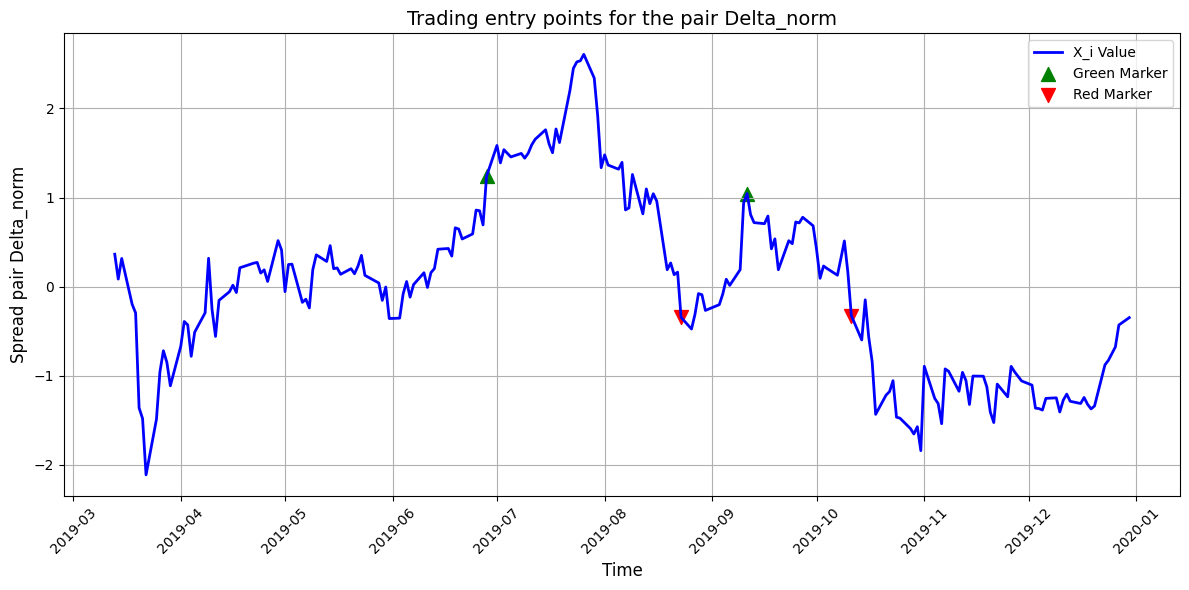

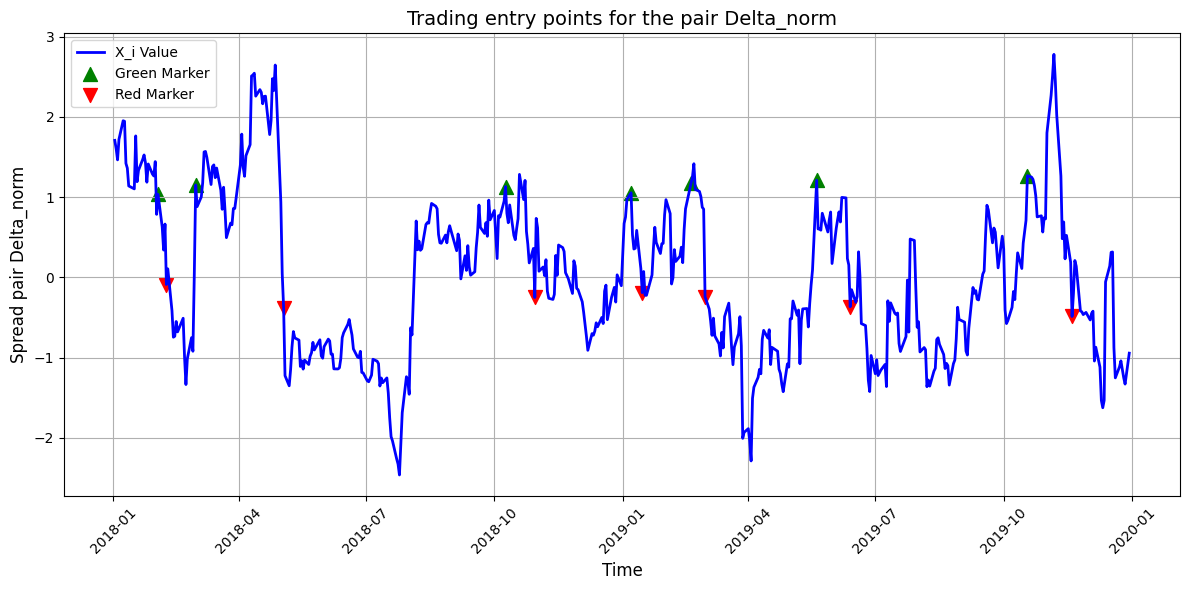

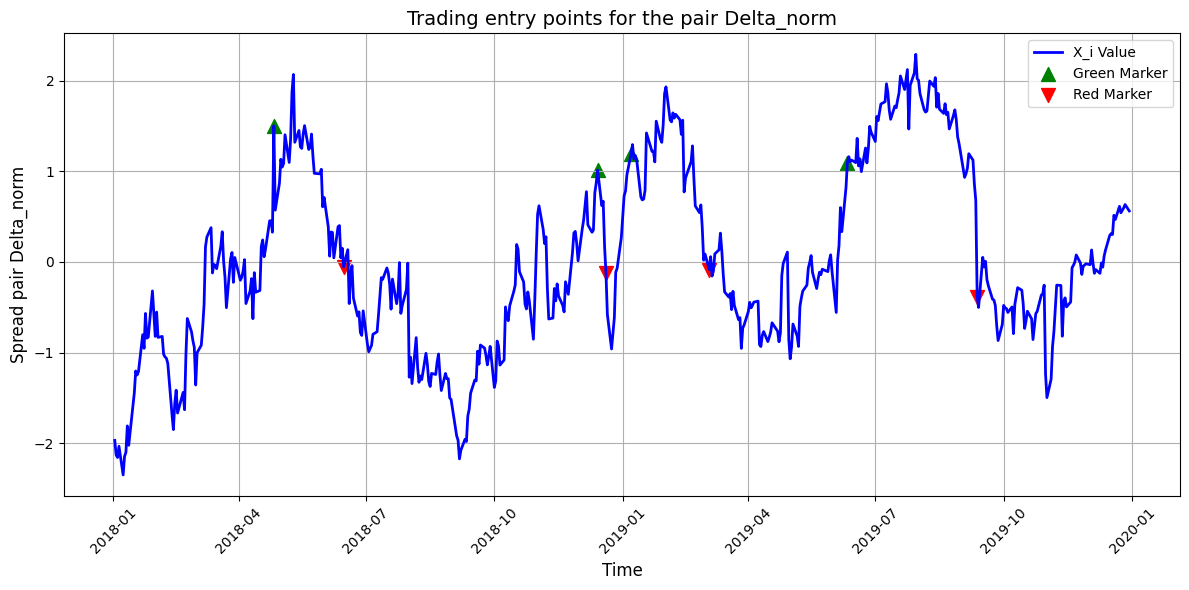

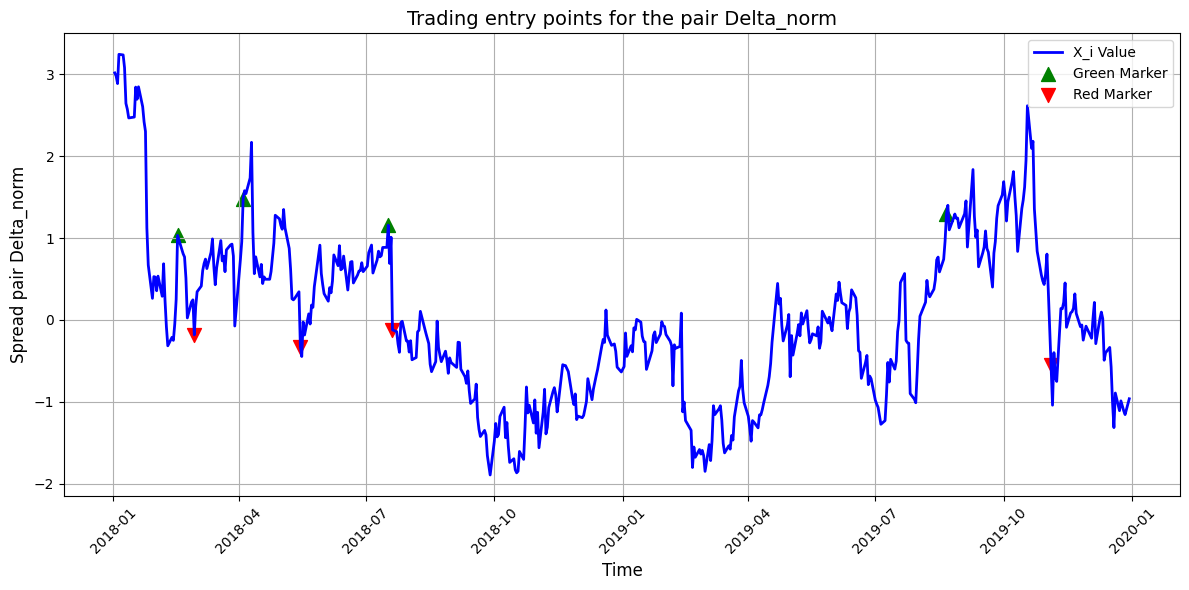

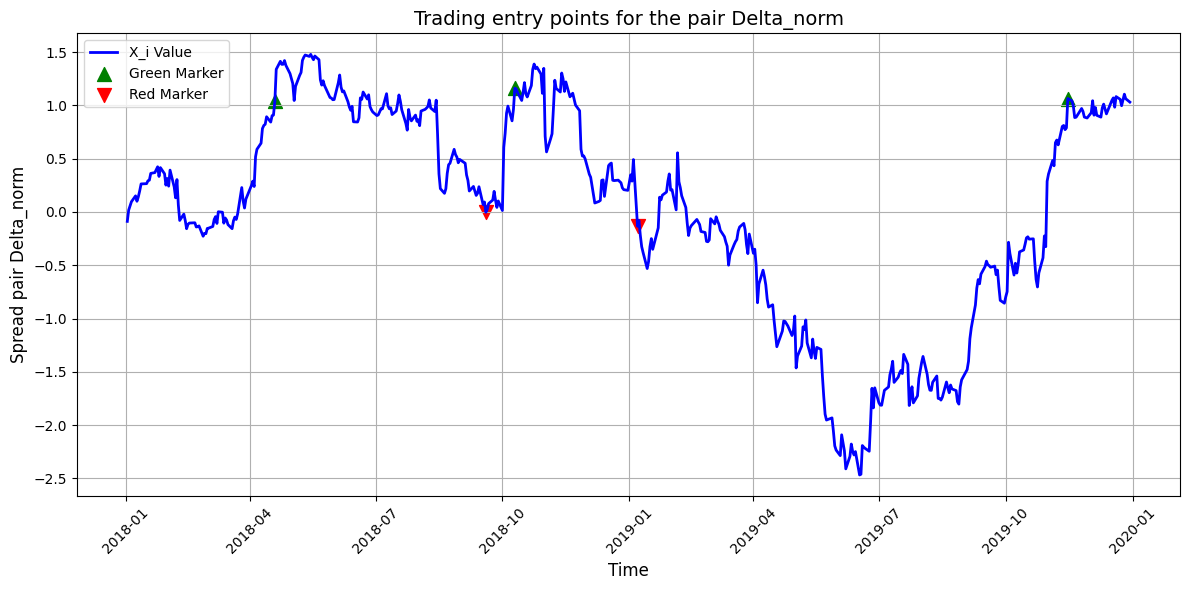

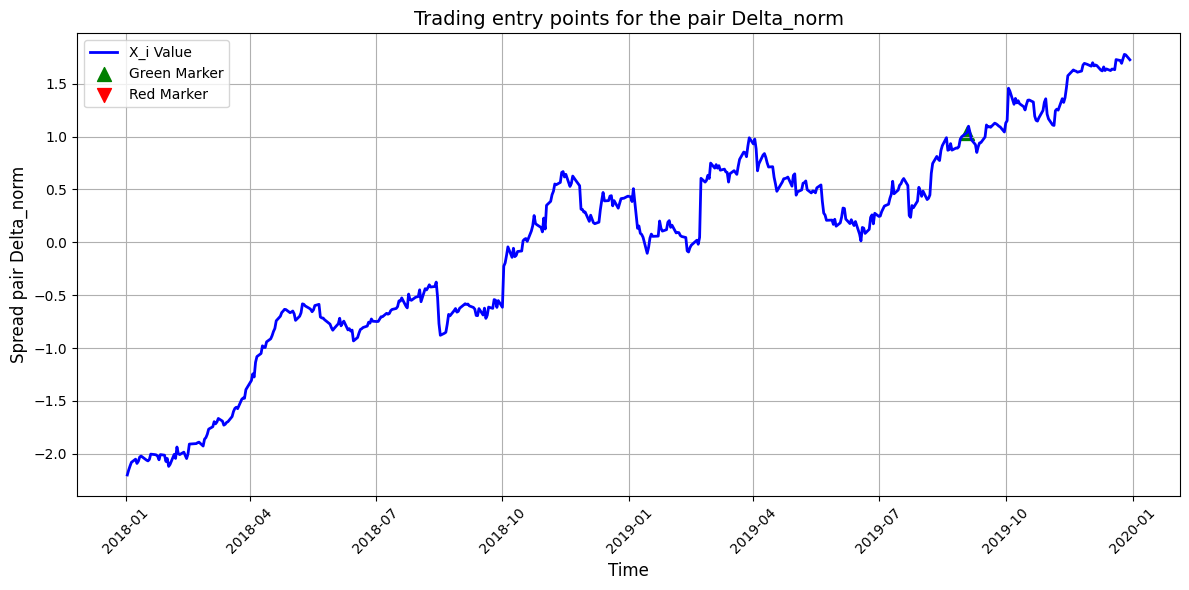

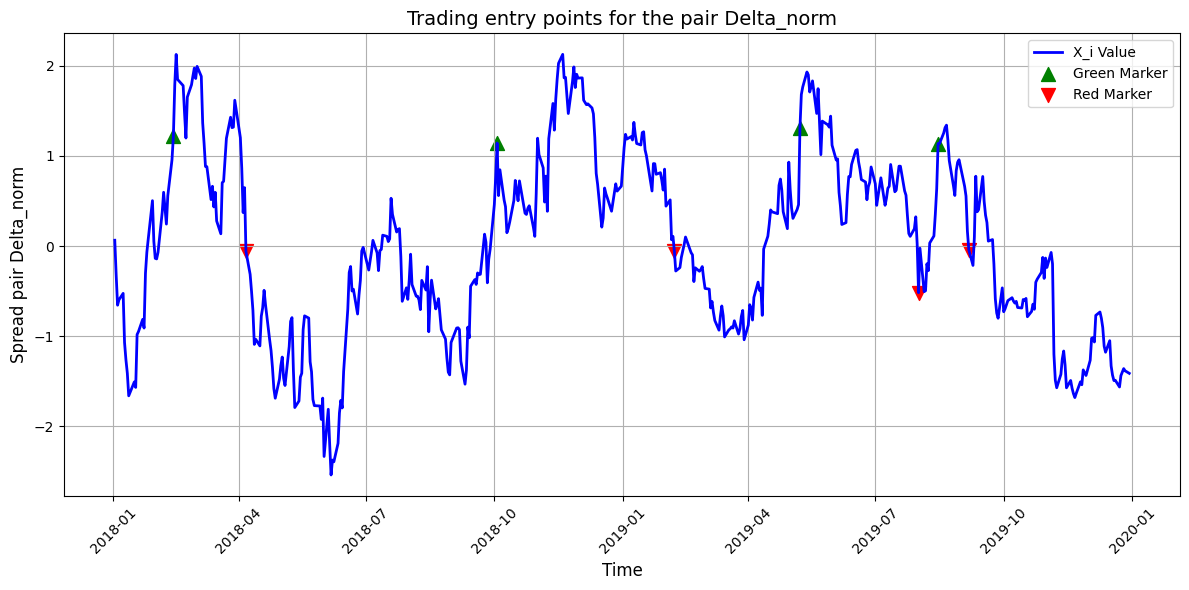

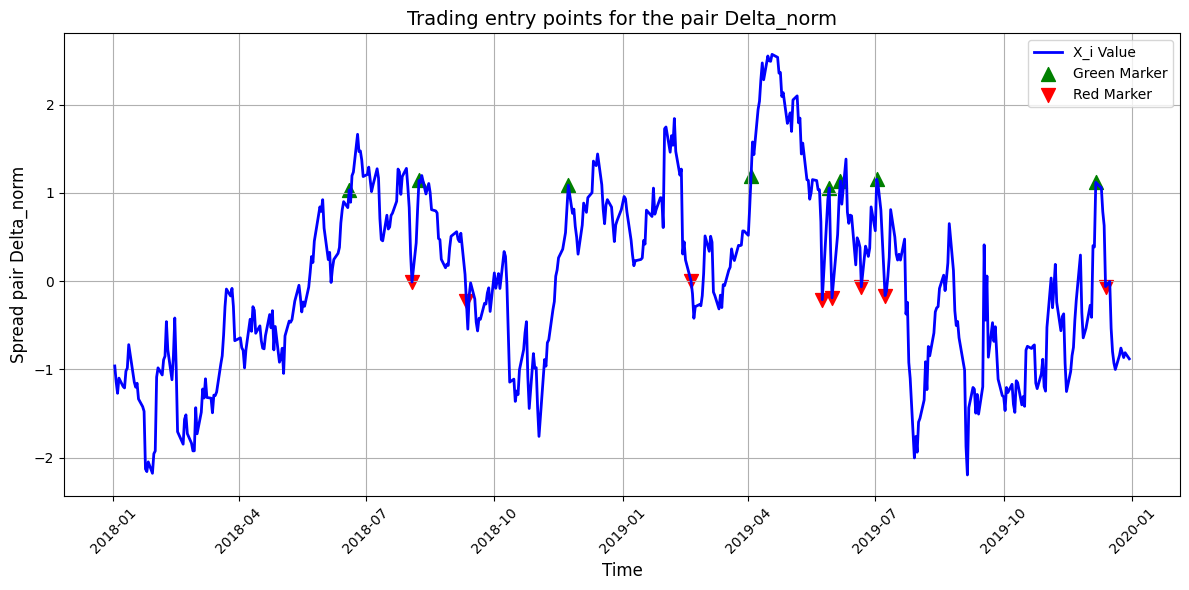

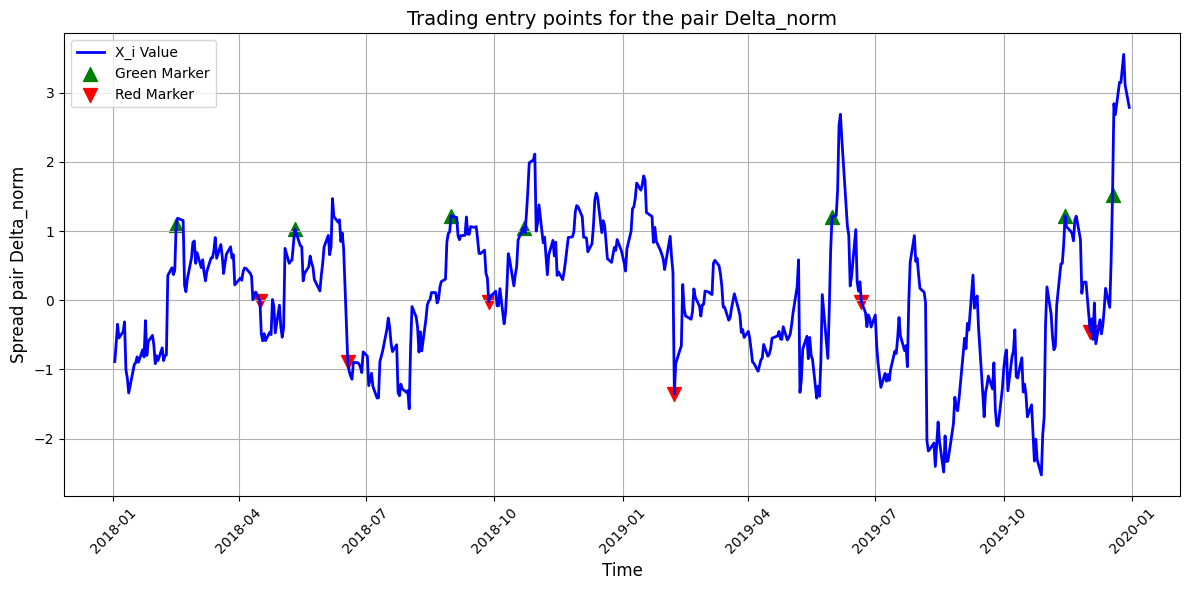

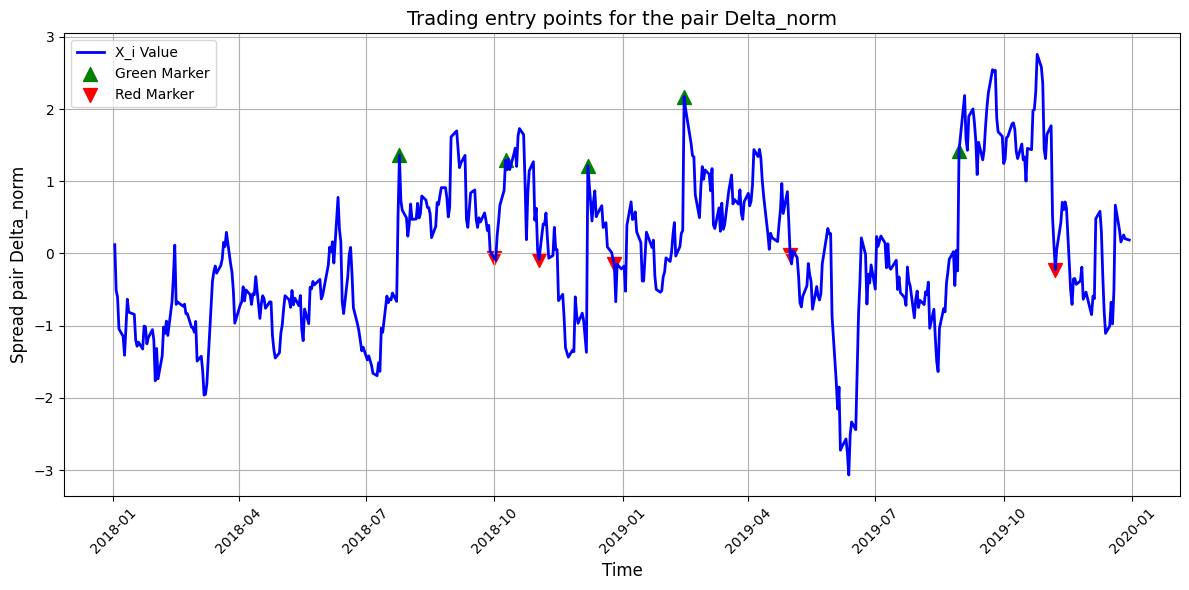

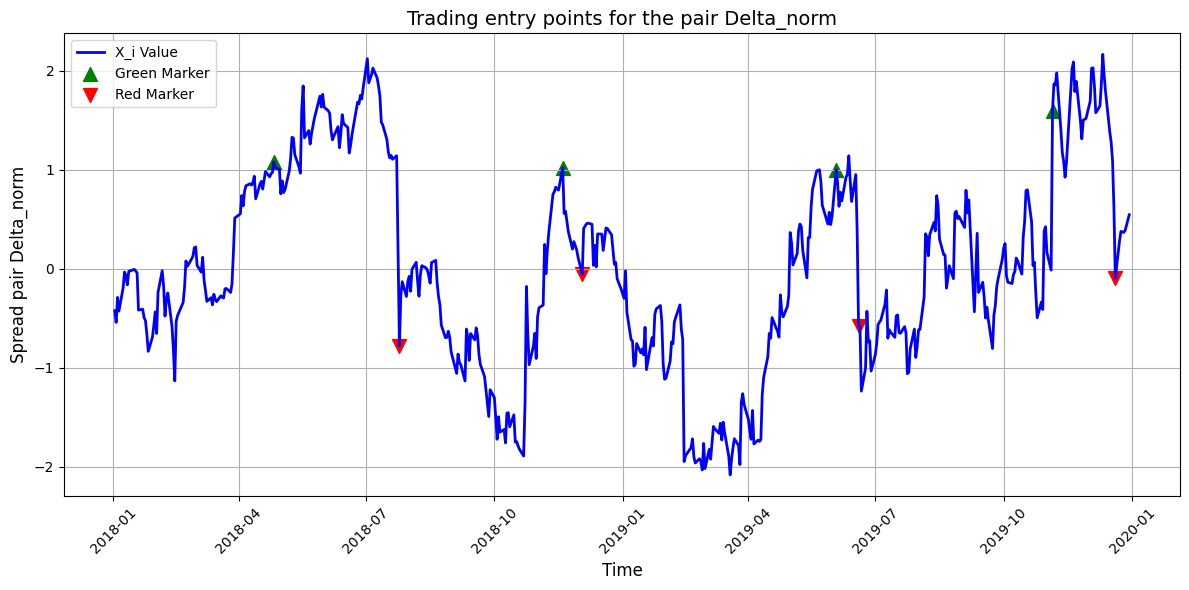

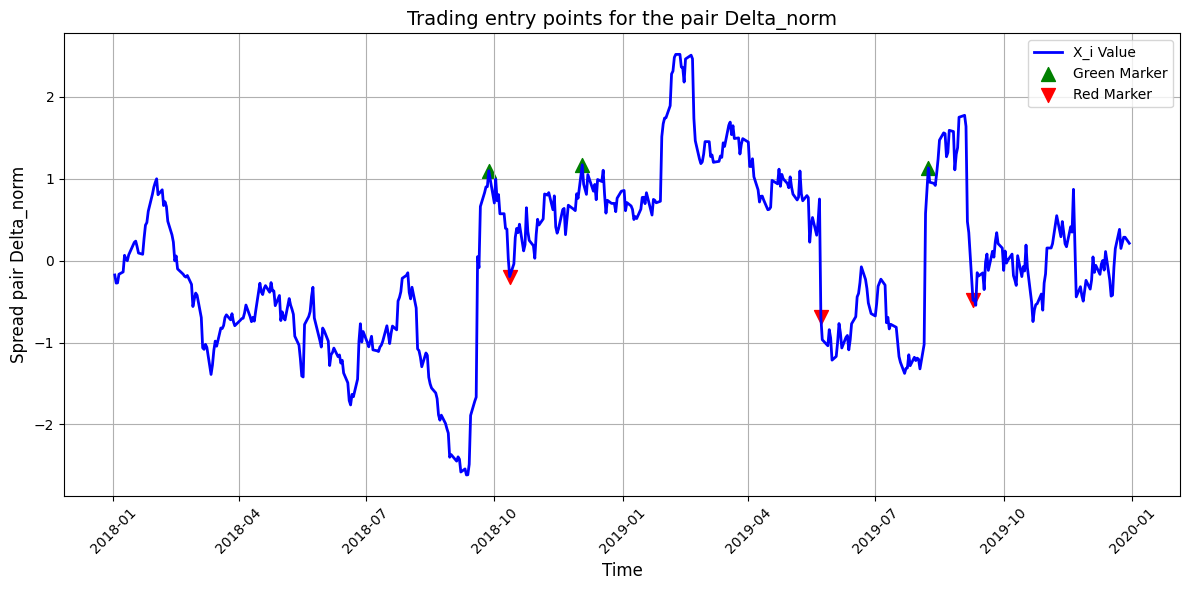

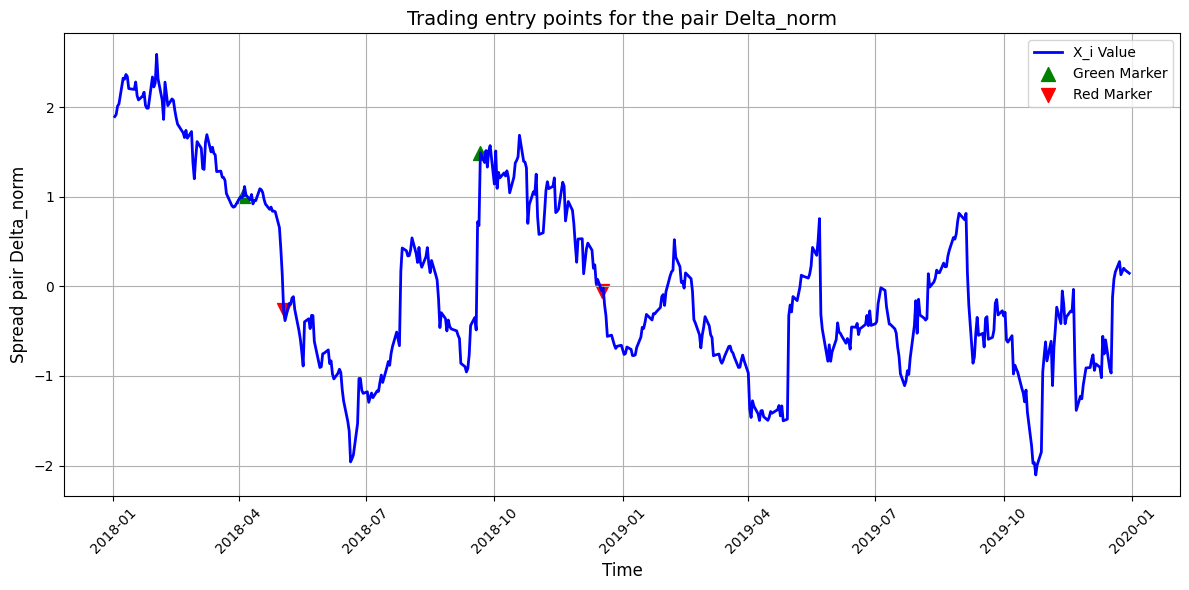

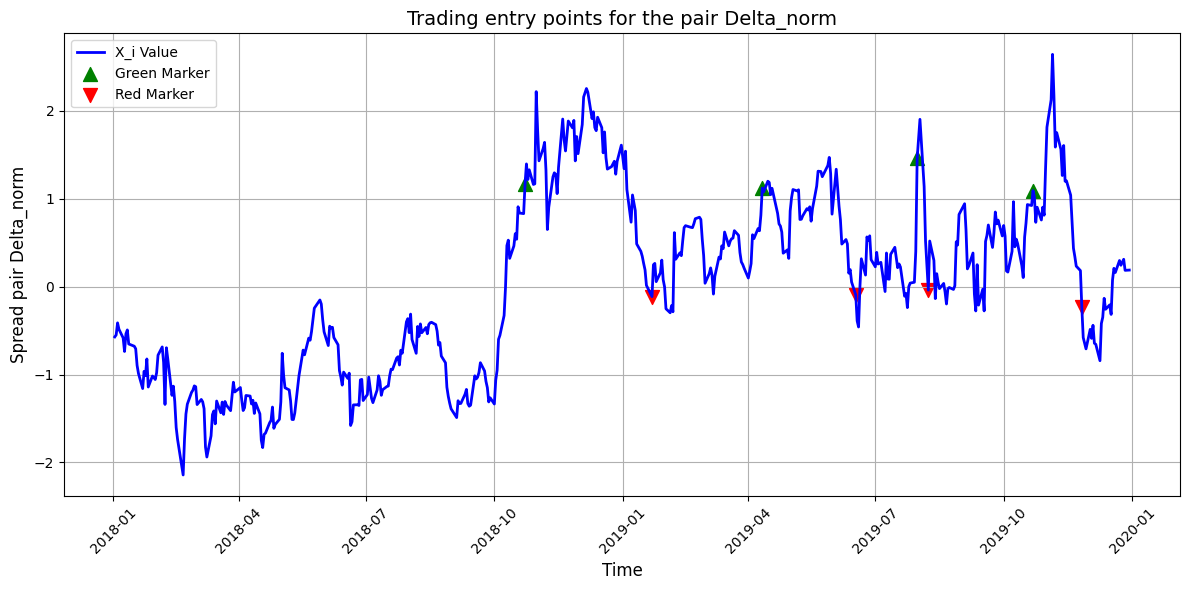

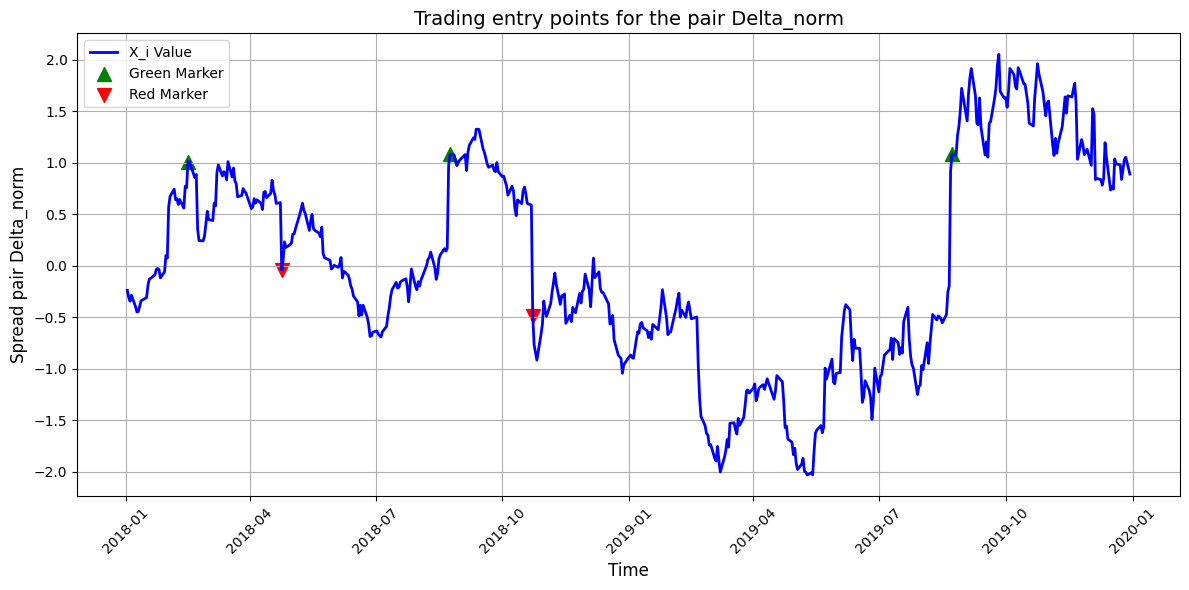

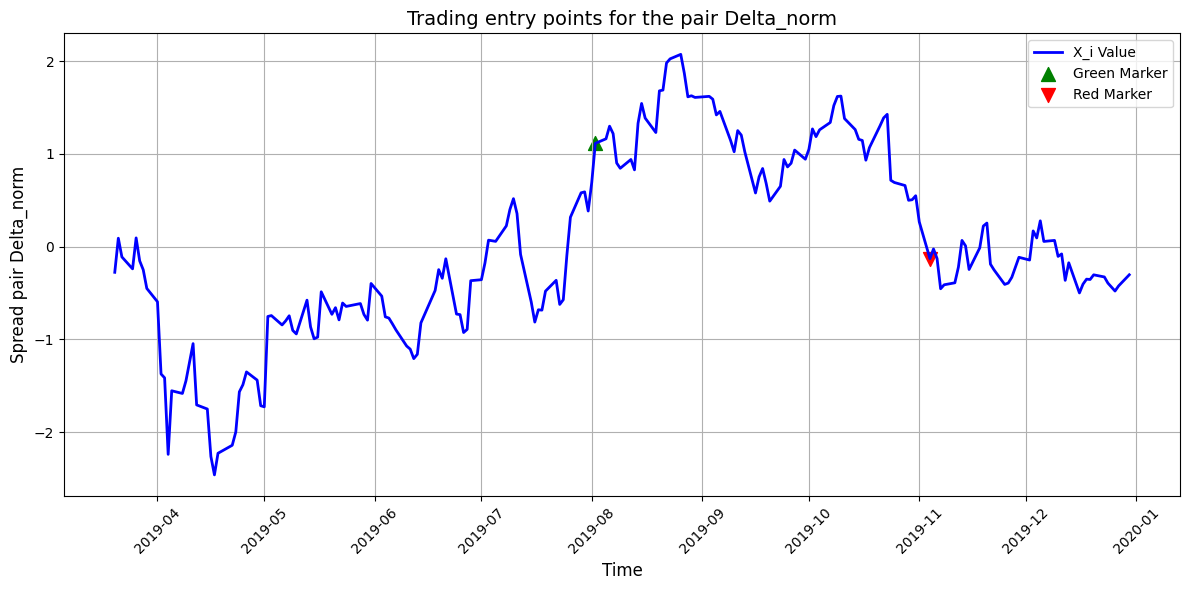

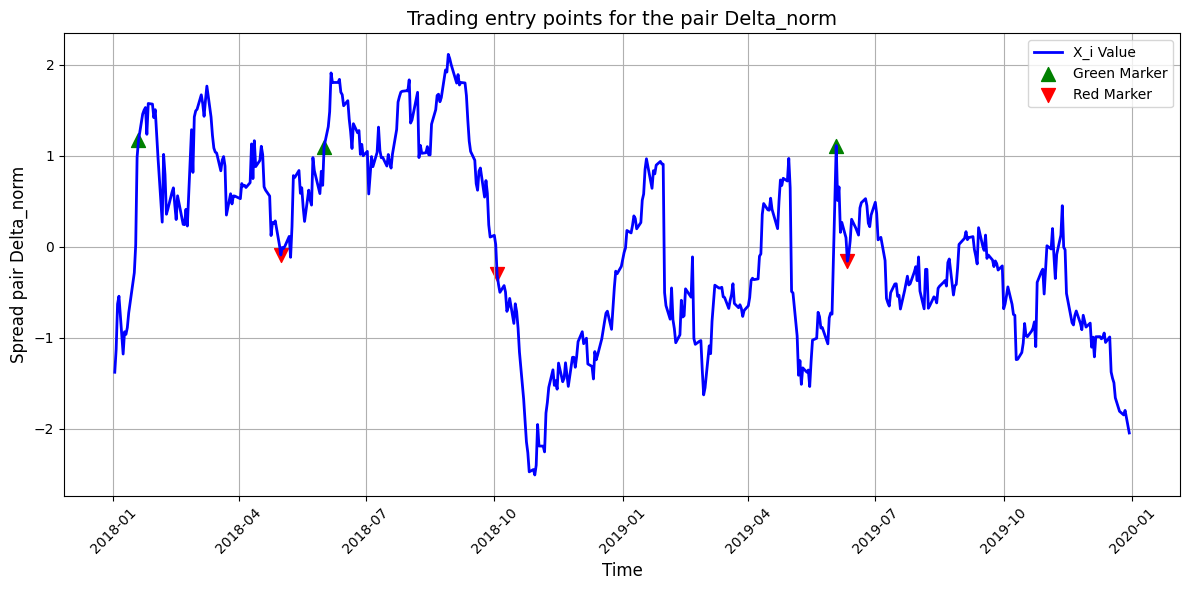

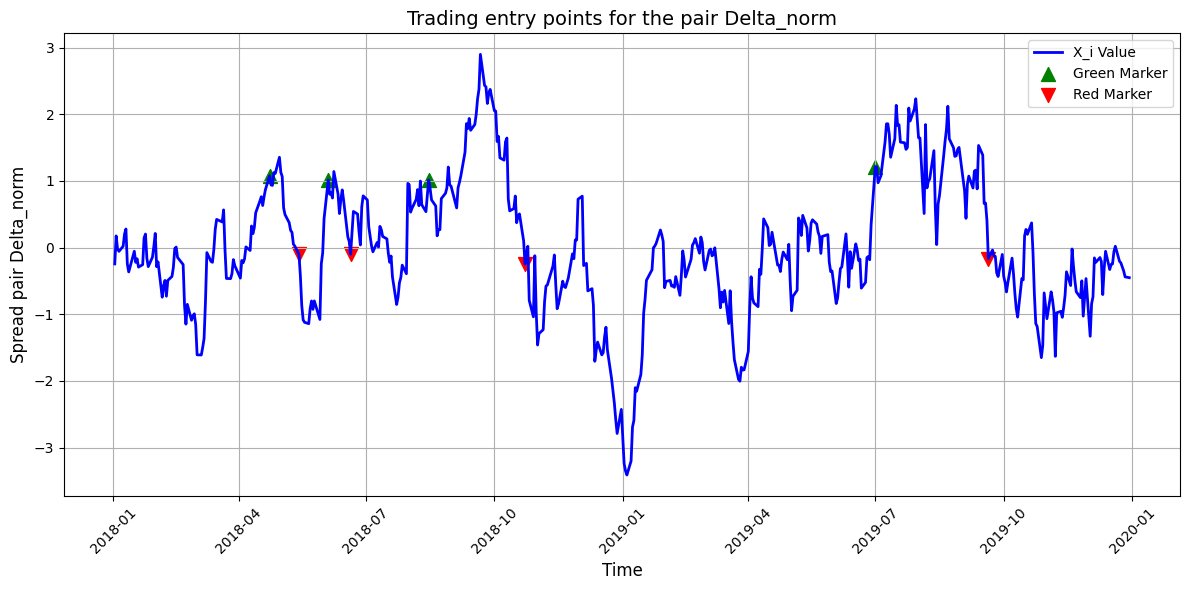

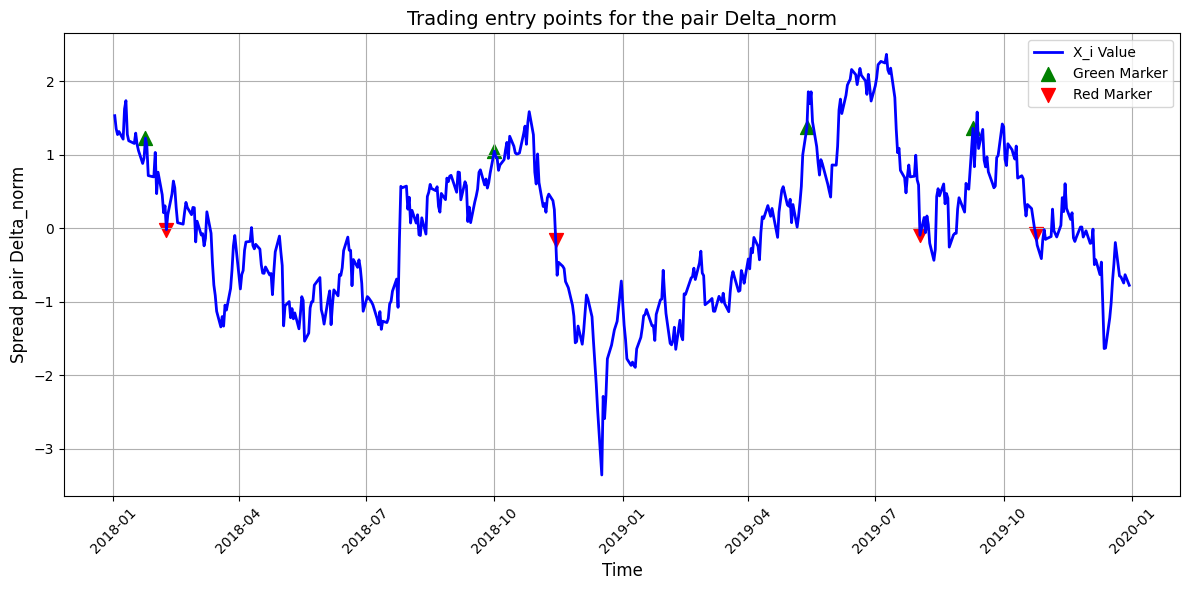

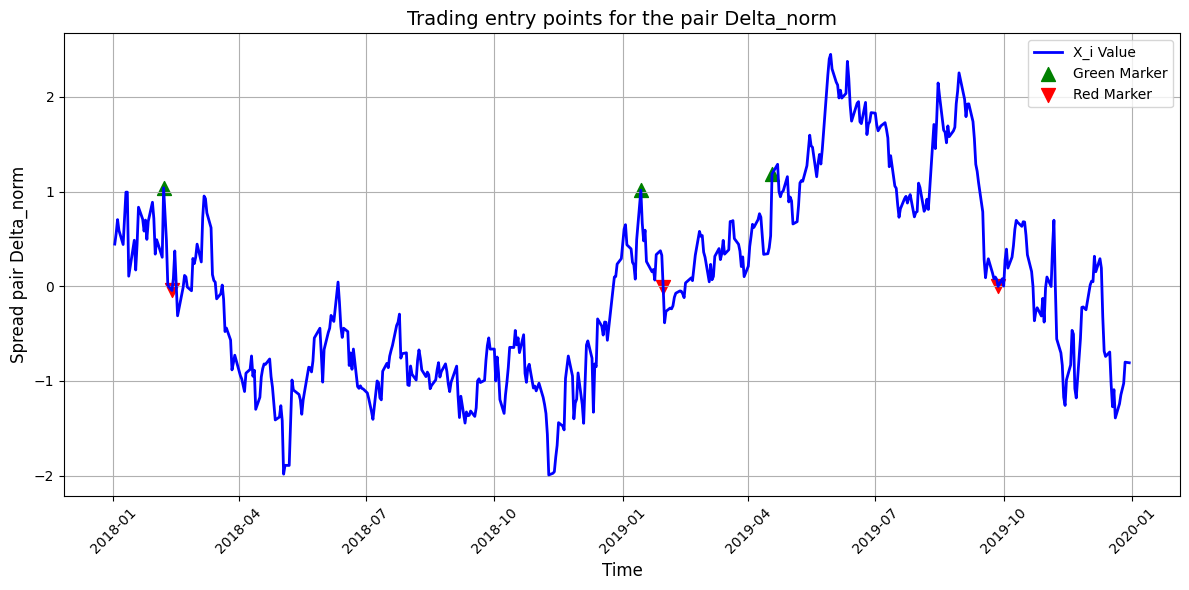

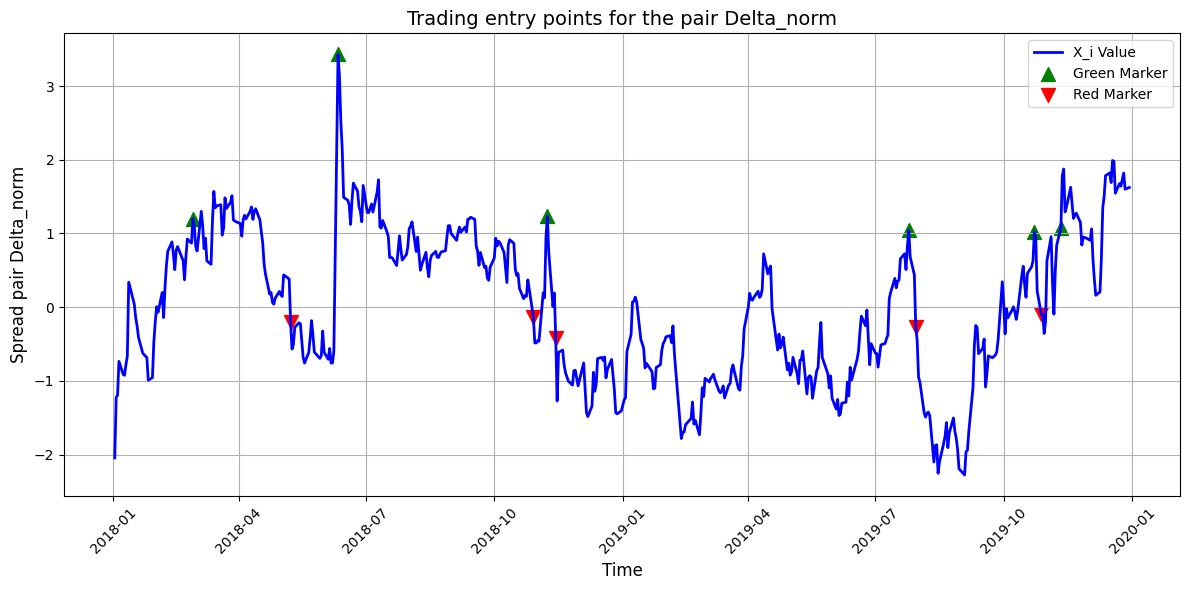

In [40]:
for key,value in dataframes_dictionnary_norm.items():
    data_viz.Entry_trading_points(value,'Delta_norm','trading_signals_buy')